# Makine Bakım Tahmini (Predictive Maintenance)

Bu notebook, makine sensör verilerini kullanarak bakım gereksinimlerini tahmin eden bir makine öğrenimi modeli oluşturmayı amaçlar.

## Veri Seti Açıklaması
- **Timestamp**: Verilerin kaydedildiği zaman.
- **Machine ID**: Makinenin benzersiz kimliği.
- **Sensor Readings** (Sıcaklık, Titreşim, Nem, Basınç, Enerji Tüketimi): Makineye ait sensör verileri.
- **Machine Status**: Makinenin durumu (0: Idle, 1: Running, 2: Failure).
- **Anomaly Flag**: Aşırı sensör değerlerini belirtir (0: Normal, 1: Anomali).
- **Predicted Remaining Life**: Tahmin edilen kalan kullanım süresi.
- **Failure Type**: Arıza nedeni (örneğin, Overheating, Electrical Fault).
- **Downtime Risk Score**: Arızalanma olasılığı (0.0, 0.5, 1.0).
- **Maintenance Required**: Hedef değişken (0: Hayır, 1: Evet).

## Amaç
- Makine bakım gereksinimlerini doğru bir şekilde tahmin etmek.
- Modelin bias-variance dengesini analiz etmek.
- Performansı optimize etmek için uygun ön işleme ve model seçimini yapmak.

In [ ]:
# Gerekli Kütüphanelerin İçe Aktarılması
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV

# Uyarıları kapat (daha temiz çıktı için)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/data.csv')

- **Timestamp**: Verilerin kaydedildiği zaman.
- **Machine ID**: Makinenin benzersiz kimliği.
- **Sensor Readings** (Sıcaklık, Titreşim, Nem, Basınç, Enerji Tüketimi): Makineye ait sensörlerden alınan veriler.
- **Machine Status**: Makinenin durumunu belirtir (Idle, Running, Failure).
- **Anomaly Flags**: Sıcaklık ve Titreşimdeki aşırı sensör değerlerini belirler.
- **Predicted Remaining Life**: Bakım gereksiniminin tahmin edilen kalan süresi.
- **Failure Type**: Arıza nedeni (Örneğin: Aşırı ısınma, Titreşim problemi).
- **Downtime Risk Score**: Makinenin arızalanma olasılığı.
- **Maintenance Required**: Bakım gerekip gerekmediğini belirten hedef değişken (0: Hayır, 1: Evet).

In [ ]:
# Veriyi yükleyelim
df = pd.read_csv('data.csv')

# İlk birkaç satırı inceleyelim
print('Veri setinin ilk 5 satırı:')
display(df.head())

# Veri setinin genel bilgilerini görelim
print('\nVeri seti bilgileri:')
df.info()

# Veri setinin boyutunu inceleyelim
print(f"\nVeri seti boyutu: {df.shape}")

Veri setinin ilk 5 satırı:


,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-28 22:01:00,12,70.52,57.21,41.55,3.20,2.55,2,0,422,Overheating,0.0,1
1,2025-01-18 19:09:00,27,70.47,30.81,56.76,1.16,2.74,2,0,153,Electrical Fault,0.0,1
2,2025-02-11 16:36:00,15,77.40,67.63,56.04,3.97,2.83,2,0,76,Vibration Issue,0.0,1
3,2025-02-25 11:10:00,4,78.15,41.90,49.71,4.36,2.38,1,0,275,Normal,0.0,0
4,2025-03-05 20:21:00,23,61.11,33.66,73.22,3.32,3.17,2,0,15,Electrical Fault,0.0,1



Veri seti bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   timestamp                 1182 non-null   object 
 1   machine_id                1182 non-null   int64  
 2   temperature               1182 non-null   float64
 3   vibration                 1182 non-null   float64
 4   humidity                  1182 non-null   float64
 5   pressure                  1182 non-null   float64
 6   energy_consumption        1182 non-null   float64
 7   machine_status            1182 non-null   int64  
 8   anomaly_flag              1182 non-null   int64  
 9   predicted_remaining_life  1182 non-null   int64  
 10  failure_type              1182 non-null   object 
 11  downtime_risk             1182 non-null   float64
 12  maintenance_required      1182 non-null   int64  
dtypes: float64(6), int64(5), object(2)
memory

In [ ]:
# Sütun isimlerini inceleyelim
print("Sütun isimleri:")
print(df.columns)

# Eksik verileri kontrol edelim
print('\nEksik veri sayısı:')
print(df.isnull().sum())

Sütun isimleri:
Index(['timestamp', 'machine_id', 'temperature', 'vibration', 'humidity',
       'pressure', 'energy_consumption', 'machine_status', 'anomaly_flag',
       'predicted_remaining_life', 'failure_type', 'downtime_risk',
       'maintenance_required'],
      dtype='object')

Eksik veri sayısı:
timestamp                   0
machine_id                  0
temperature                 0
vibration                   0
humidity                    0
pressure                    0
energy_consumption          0
machine_status              0
anomaly_flag                0
predicted_remaining_life    0
failure_type                0
downtime_risk               0
maintenance_required        0
dtype: int64


In [ ]:
# Veri setinin özet istatistiklerini görelim
print('Özet istatistikler:')
df.describe()

Özet istatistikler:


,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,downtime_risk,maintenance_required
count,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000
mean,26.211506,77.222479,51.154848,55.069002,2.971421,2.736041,1.177665,0.233503,191.200508,0.233494,0.500000
std,14.186347,11.196393,15.780467,14.456184,1.145589,1.287416,0.549567,0.423238,156.225167,0.423223,0.500212
min,1.000000,46.190000,6.960000,30.000000,1.010000,0.510000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,14.000000,69.592500,40.302500,42.860000,1.930000,1.620000,1.000000,0.000000,39.000000,0.000000,0.000000
50%,26.000000,76.410000,50.325000,54.795000,2.995000,2.720000,1.000000,0.000000,164.000000,0.000000,0.500000
75%,38.750000,85.205000,61.177500,67.357500,3.967500,3.840000,2.000000,0.000000,325.750000,0.000000,1.000000
max,50.000000,108.070000,98.860000,79.990000,4.990000,5.000000,2.000000,1.000000,499.000000,1.000000,1.000000


In [ ]:
data.columns #Veri kolonlarını veriri

Index(['timestamp', 'machine_id', 'temperature', 'vibration', 'humidity',
       'pressure', 'energy_consumption', 'machine_status', 'anomaly_flag',
       'predicted_remaining_life', 'failure_type', 'downtime_risk',
       'maintenance_required'],
      dtype='object')

In [ ]:
# Benzersiz arıza türlerini inceleyelim
unique_failures = df['failure_type'].unique()
print("Benzersiz Hata Türleri:")
print(unique_failures)
print("===========================")
print("Hata Türü Frekansları:")
print(df['failure_type'].value_counts())

Benzersiz Hata Türleri:
['Overheating' 'Electrical Fault' 'Vibration Issue' 'Normal'
 'Pressure Drop']
Hata Türü Frekansları:
failure_type
Normal              939
Vibration Issue      94
Overheating          60
Pressure Drop        59
Electrical Fault     30
Name: count, dtype: int64


IsolationForest algoritması makine öğrenimi temelli bri algoritmadır. Bizim için aykırı değerli tespit eder

In [ ]:
# Sensör verilerinde Outlier Detection yapalım
sensor_features = ['temperature', 'vibration', 'humidity', 'pressure', 'energy_consumption']
iso_forest = IsolationForest(contamination=0.05, random_state=42)

for feature in sensor_features:
    iso_forest.fit(df[[feature]])
    df[f"{feature}_outlier"] = iso_forest.predict(df[[feature]])
    df[f"{feature}_outlier"] = df[f"{feature}_outlier"].apply(lambda x: 1 if x == -1 else 0)
    print(f"{feature} için tespit edilen aykırı değer sayısı: {df[f'{feature}_outlier'].sum()}")
print("\n======================================")

temperature için tespit edilen aykırı değer sayısı: 60
vibration için tespit edilen aykırı değer sayısı: 60
humidity için tespit edilen aykırı değer sayısı: 60
pressure için tespit edilen aykırı değer sayısı: 60
energy_consumption için tespit edilen aykırı değer sayısı: 59



Bu çıktı da ise tüm sensörlede hemen hemen aynı sayıda aykırı değer çıkması veri setini homojen olduğunu gösteriyor.

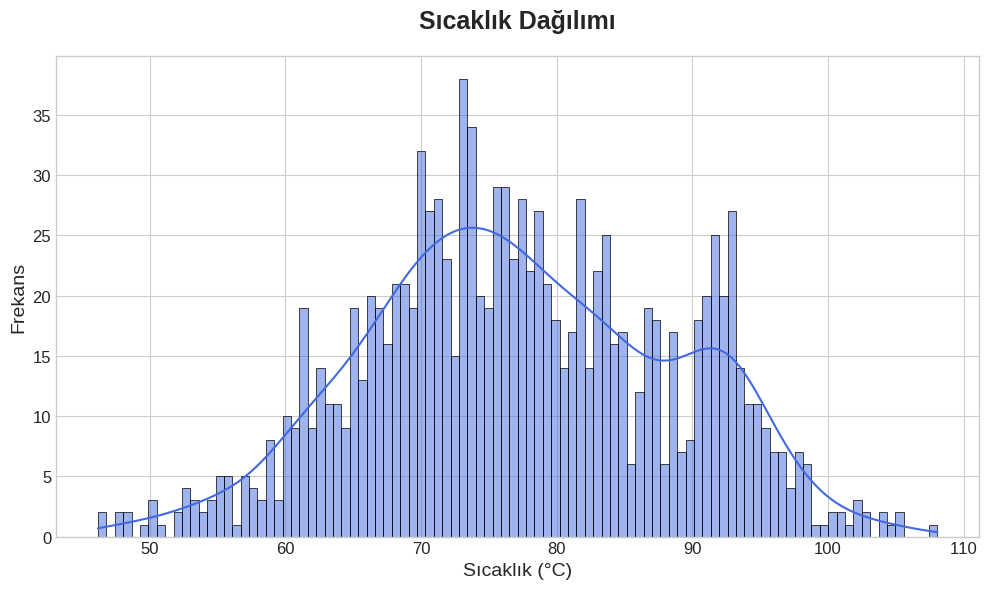

In [ ]:
# "temperature" sütununun histogram ve KDE (yoğunluk) grafiğini çizer
plt.figure(figsize=(10, 6))

sns.histplot(df['temperature'], kde=True, bins=100, color='royalblue', edgecolor='black')

plt.title('Sıcaklık Dağılımı', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sıcaklık (°C)', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

Sıcaklık dağılımı grafiğine baktığımızda, genelde 70-90°C arasında yoğunlaşmış gibi görünüyor. KDE eğrisi de bunu doğruluyor..

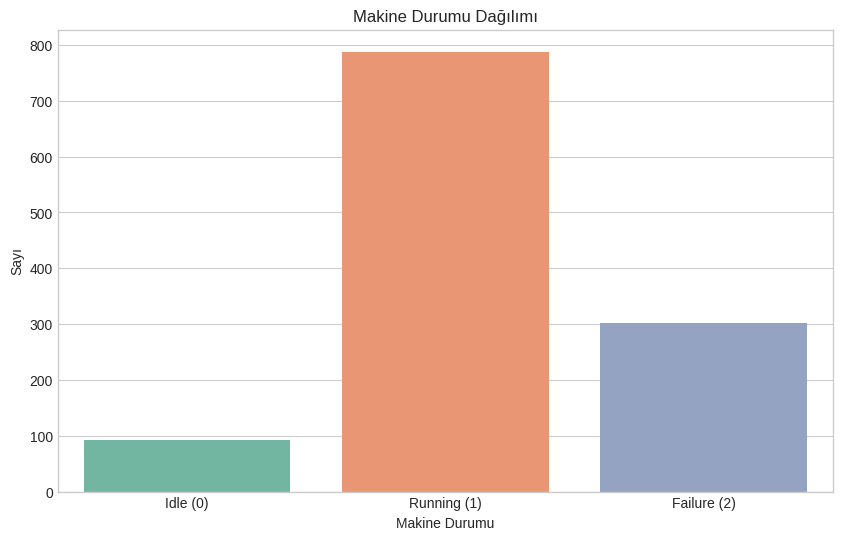

In [ ]:
# Makine durumu sayıları
plt.figure(figsize=(10, 6))
sns.countplot(x='machine_status', data=data, palette='Set2')
plt.title('Makine Durumu Dağılımı')
plt.xlabel('Makine Durumu')
plt.ylabel('Sayı')
plt.xticks([0, 1, 2], ['Idle (0)', 'Running (1)', 'Failure (2)'])
plt.show()

Makine durumu dağılımına baktığımızda, "Running" (1) durumu açık ara en sık görünüyor, yaklaşık 750 civarında. "Failure" (2) durumu 300 civarında, "Idle" (0) ise 100’e yakın. Makine genelde çalışır halde, ama arıza sayısı da az değil.

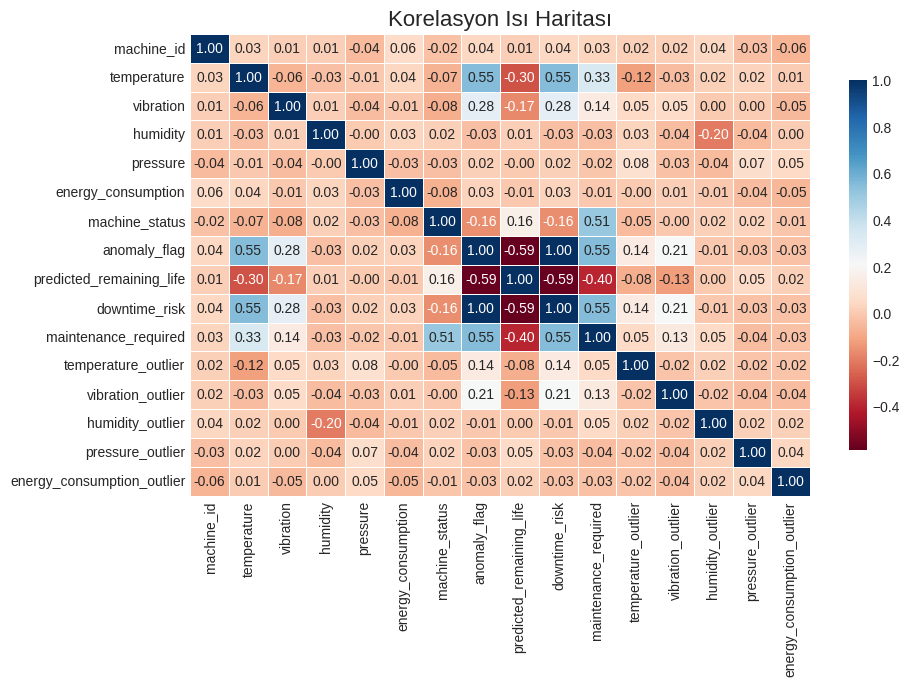

In [ ]:
# Korelasyon haritası
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_df = df[numeric_cols]

correlation = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Korelasyon Isı Haritası', fontsize=16)
plt.show()

Korelasyon ısı haritasına baktığımızda, "maintenance_required" ile "anomaly_flag" ve "downtime_risk" arasında güçlü bir pozitif ilişki var (0.59). Sıcaklık (temperature) ve titreşim (vibration) ise kendi aykırı değerleriyle (outlier) belirgin bir korelasyon gösteriyor, ama genelde değişkenler arasında düşük korelasyonlar dikkat çekiyor.

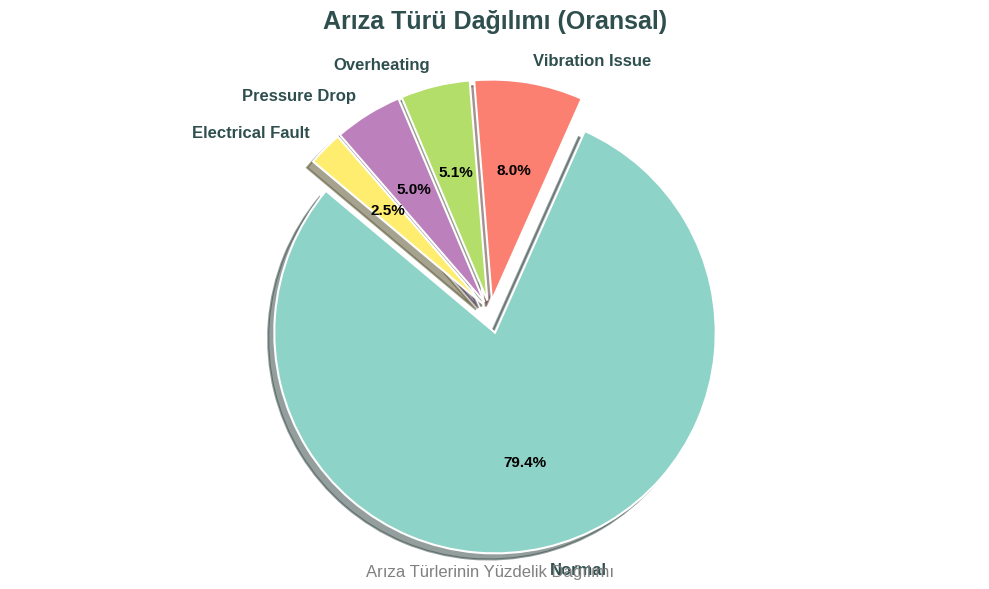

In [ ]:
# "failure_type" sütunundaki arıza türlerinin oranlarını pasta grafiği ile görselleştirilmesi
failure_counts = df['failure_type'].value_counts()

plt.figure(figsize=(10, 6), facecolor='white')
plt.style.use('seaborn-v0_8-whitegrid')  # Modern ve temiz bir tema

explode = [0.1 if i == failure_counts.idxmax() else 0.05 for i in failure_counts.index]

colors = plt.cm.Set3(np.linspace(0, 1, len(failure_counts)))

wedges, texts, autotexts = plt.pie(
    failure_counts,
    labels=failure_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    shadow=True,
    explode=explode,
    textprops={'fontsize': 12, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(11)
    autotext.set_weight('bold')

for text in texts:
    text.set_fontsize(12)
    text.set_color('darkslategray')

plt.title('Arıza Türü Dağılımı (Oransal)', fontsize=18, weight='bold', pad=20, color='darkslategray')
plt.text(0, -1.2, 'Arıza Türlerinin Yüzdelik Dağılımı', fontsize=12, ha='center', color='gray')

plt.axis('equal')
plt.tight_layout()
plt.show()

Arıza türü dağılımına bakıyorum, %79,4 normal durum hakim. Arızalar arasında "Vibration Issue" %8 ile en yüksek, "Overheating" %5,1 ve "Pressure Drop" %5 ile dikkat çekiyor. Diğer arızalar daha az oranda, genelde sorunlar titreşim ve aşırı ısınma odaklı gibi.

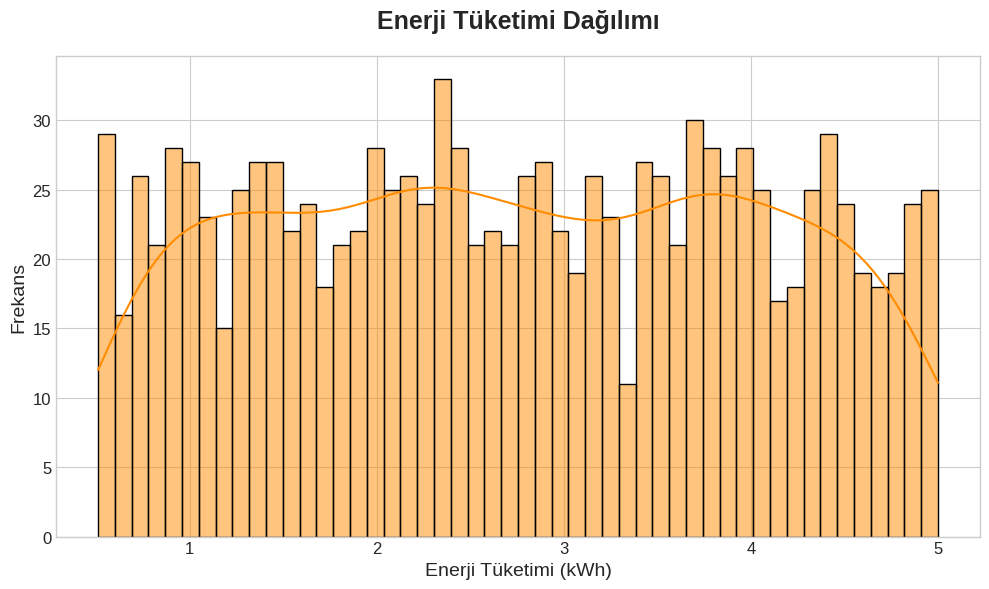

In [ ]:
# Enerji Tüketimi Dağılımı
plt.figure(figsize=(10, 6))

sns.histplot(df['energy_consumption'], kde=True, bins=50, color='darkorange', edgecolor='black')

plt.title('Enerji Tüketimi Dağılımı', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Enerji Tüketimi (kWh)', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

Enerji tüketimi dağılımına baktığımızda, genelde 1-4 kWh arasında yoğunlaşmış, en çok 2-3 kWh civarında değer var. KDE eğrisi de bunu destekliyor, ama birkaç tepe noktası dikkat çekiyor; tüketimde farklı pattern’ler olabilir.

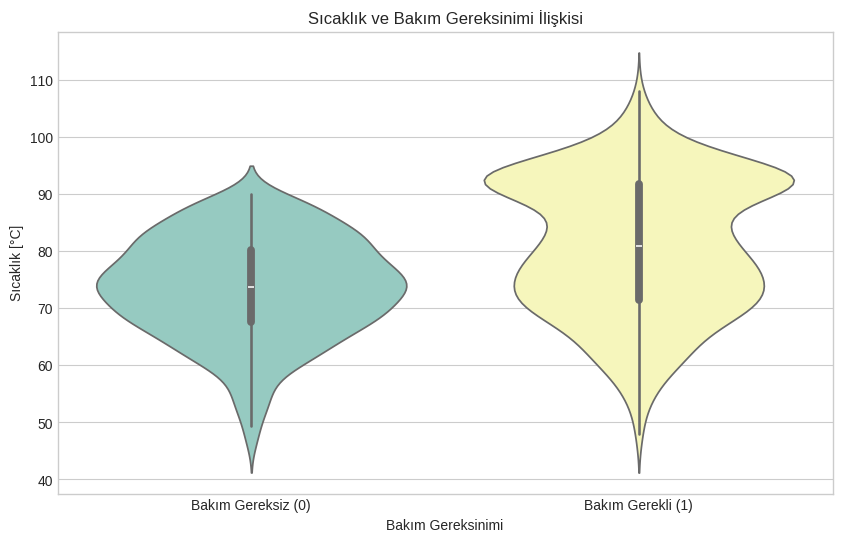

In [ ]:
# Sıcaklık ve Bakım Gereksinimi İlişkisi
plt.figure(figsize=(10, 6))
sns.violinplot(x='maintenance_required', y='temperature', data=df, palette='Set3')
plt.title('Sıcaklık ve Bakım Gereksinimi İlişkisi')
plt.xlabel('Bakım Gereksinimi')
plt.ylabel('Sıcaklık [°C]')
plt.xticks([0, 1], ['Bakım Gereksiz (0)', 'Bakım Gerekli (1)'])
plt.show()

Sıcaklık ve bakım gereksinimi ilişkisine baktığımızda, bakım gerektirmeyen (0) makineler genelde 50-100°C arasında yoğunlaşmış, ama bakım gerekenler (1) daha dar bir aralıkta, 70-90°C civarında toplanmış. Bakım ihtiyacı olan makinelerin sıcaklık dağılımı daha sıkışık görünüyor.

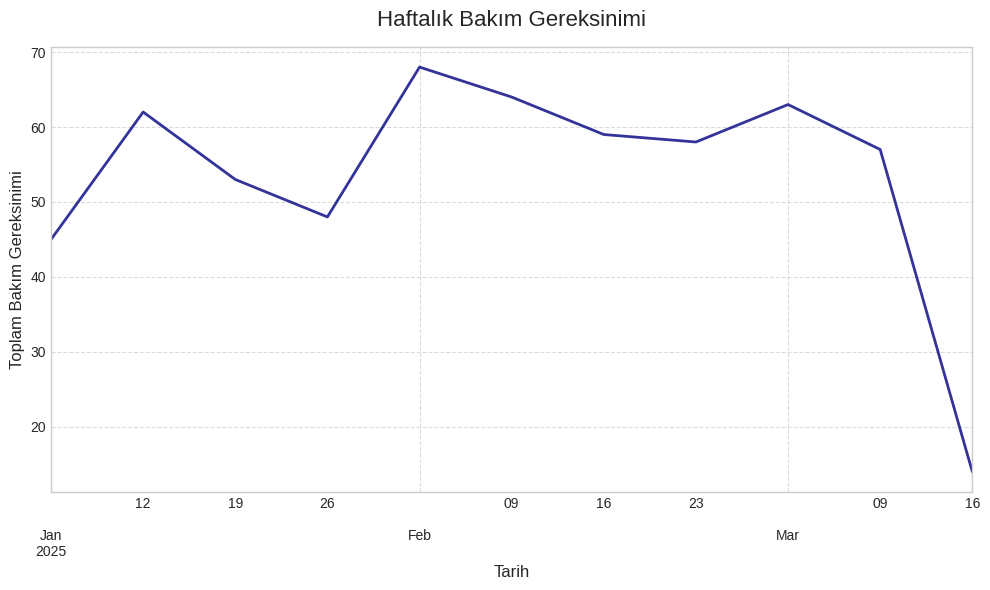

In [ ]:
# Haftalık toplam bakım gereksinimlerini zaman serisi grafiğiyle görselleştirilmesi
data['timestamp'] = pd.to_datetime(data['timestamp'])
veri = data.sort_values('timestamp')
haftalik_bakim = veri.resample('W', on='timestamp')['maintenance_required'].sum()

plt.figure(figsize=(10, 6))

haftalik_bakim.plot(linewidth=2, color='navy', alpha=0.8)

plt.title('Haftalık Bakım Gereksinimi', fontsize=16, pad=15)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Toplam Bakım Gereksinimi', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Haftalık bakım gereksinimine baktığımızda, Ocak ortasında 50 civarında başlamış, Şubat başında 70’e kadar yükselmiş. Sonra genelde 60 civarında seyretmiş ama Mart ortasında 20’ye kadar düşmüş. Bakım ihtiyacı zamanla azalmış gibi görünüyor.

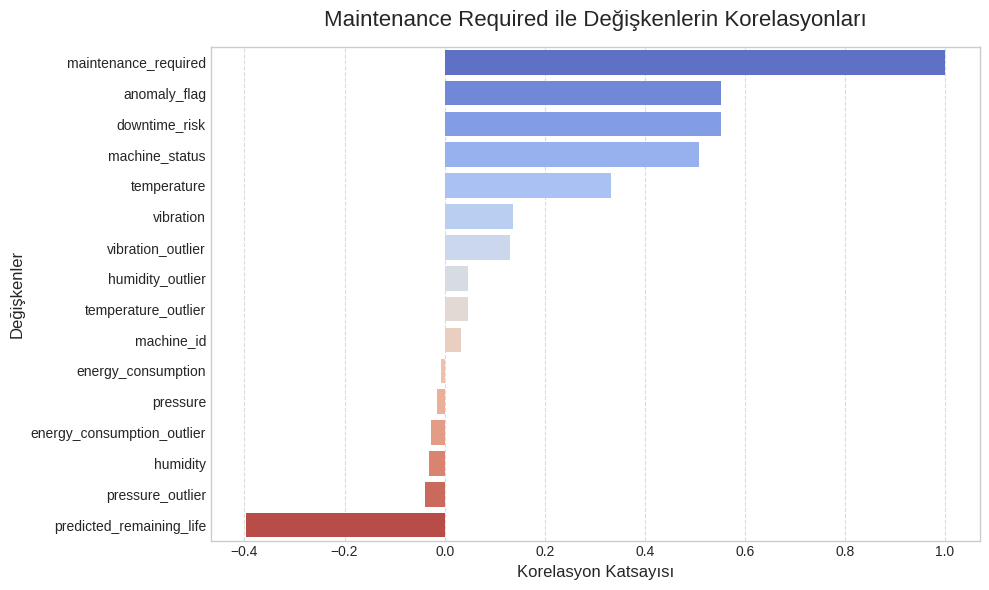

In [ ]:
# "maintenance_required" ile diğer sayısal değişkenler arasındaki korelasyonları bar grafiği ile gösterilmesi
numeric_data = df.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
maintenance_correlations = correlation_matrix['maintenance_required'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=maintenance_correlations.values, y=maintenance_correlations.index, palette='coolwarm')

plt.title('Maintenance Required ile Değişkenlerin Korelasyonları', fontsize=16, pad=15)
plt.xlabel('Korelasyon Katsayısı', fontsize=12)
plt.ylabel('Değişkenler', fontsize=12)

plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

One-Hot Encoding ya da Ordinal Encoding gibi alternatif
yöntemlerin "hafıza" sağlayarak daha sağlıklı veri işleme uygulamalarına nasıl olanak tanıdığını teknik detaylarıyla inceledik. Sonuç olarak, pandas kütüphanesinde var olan get_dummie'nin statik yapısının, üretim düzeyindeki makine öğrenimi görevlerinin değişken doğasına uygun olmadığını net bir şekilde gördük. Bu yüzden projemizde **from sklearn.preprocessing import OneHotEncoder** kütüphanesi ile encoding işlemini yaptık.

Aynı zamanda get_dummie, test verilerinden gelen bilgilerin eğitim sürecine karışmasına neden olabilir. Bu da modelin doğruluğunu yapay şekilde artırır ve gerçek hayatta kötü performansa sebep olur.

Burada ***OneHotEncoder(sparse_output=False, handle_unknown='ignore')*** kısmındaki handle_unknown kısmı bilinmeyen değer gelirse onu 'ignore' etmek için verilmiş bir parametredir. Eğer bu parametre olmaz ise bilinmeyen bir parametre gelirse kod çalışmayacaktır.

**X = data.drop(columns=['maintenance_required', 'failure_type'])** *failure_type*'ı da çıkarma sebebimiz hedef değikenile çok yakın bir veri olması yani **maintenance_required** normal ise bakım gerek yok modelimiz bunu çıkarabilir buna da data leakage denir.

Yukarıdaki korelasyon ısı haritasına bakarsak downtime_risk ile anomaly_flag korelasyonları 1 (yani bu iki değer aynı veri) bu yüzden aşağıdaki modelimize downtime_risk'i dahil etmedik.

In [ ]:
# ANA Modelimizi Eğitelim

# Girdi (X) ve hedef (y) değişkenlerini ayırıyoruz
X = data.drop(columns=['maintenance_required', 'failure_type'])  # 'failure_type' hedef değişkenle doğrudan ilişkili olduğu için çıkarıldı
y = data['maintenance_required']

# Eğer zaman damgası sütunu varsa, modelde kullanılmayacağı için çıkarılır
if 'timestamp' in X.columns:
    X = X.drop(columns=['timestamp'])

# Sayısal ve kategorik sütunları ayrı olarak tanımlıyoruz
numerical_cols = ['temperature', 'vibration', 'humidity', 'pressure',
                  'energy_consumption', 'anomaly_flag', 'machine_status', 'predicted_remaining_life']
categorical_cols = ['machine_id']

# Sayısal veriler için dönüşüm: eksik veri doldurma + ölçekleme (0-1 aralığına çekme)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Eksik veri varsa ortalama ile doldur (veri setimizde eksik yok ama yapı tamam)
    ('scaler', StandardScaler())  # Verileri normalize eder (ortalama=0, std=1)
])

# Kategorik veriler için dönüşüm: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Sayısal ve kategorik verileri birlikte dönüştürmek için sütun dönüştürücü tanımlıyoruz
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Yukarıda belirtilmeyen tüm sütunları at (varsayılan ama açıkça yazmak okunabilirliği artırır)
)

# Tüm işlem adımlarını içeren pipeline (ön işleme + sınıflandırıcı modeli)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='tanh',
        solver='adam',
        alpha=0.0001,
        learning_rate='constant',
        max_iter=150,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=10
    ))
])

# Eğitim ve test verilerini ayır (stratify ile sınıf dengesini koruruz)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if y.nunique() > 1 else None  # Eğer hedef değişkende yalnızca bir sınıf varsa stratify uygulama
)

print("Model egitiliyor...")
pipeline.fit(X_train, y_train)
print("Model egitimi tamamlandi.")

print("\nTest seti uzerinde tahmin yapiliyor...")
y_pred = pipeline.predict(X_test)

print("\n======================================")
print("Karışıklık Matrisi:")
print(confusion_matrix(y_test, y_pred))  # Hangi sınıfın ne kadar doğru/yanlış tahmin edildiğini gösterir
print("\n======================================")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))  # Precision, recall, f1-score gibi metrikleri sunar
print("\n======================================")
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Doğruluk Oranı: {accuracy:.4f}")  # Toplam doğruluk oranı
print("\n======================================")
feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"\nÖzellik sayısı: {len(feature_names_out)}")  # Modelde kullanılan toplam özellik (One-Hot sonrası artabilir)
print("\n======================================")

Model egitiliyor...
Model egitimi tamamlandi.

Test seti uzerinde tahmin yapiliyor...

Karışıklık Matrisi:
[[118   1]
 [  8 110]]


Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       119
           1       0.99      0.93      0.96       118

    accuracy                           0.96       237
   macro avg       0.96      0.96      0.96       237
weighted avg       0.96      0.96      0.96       237



Model Dogruluk Oranı: 0.9620


Özellik sayısı: 58



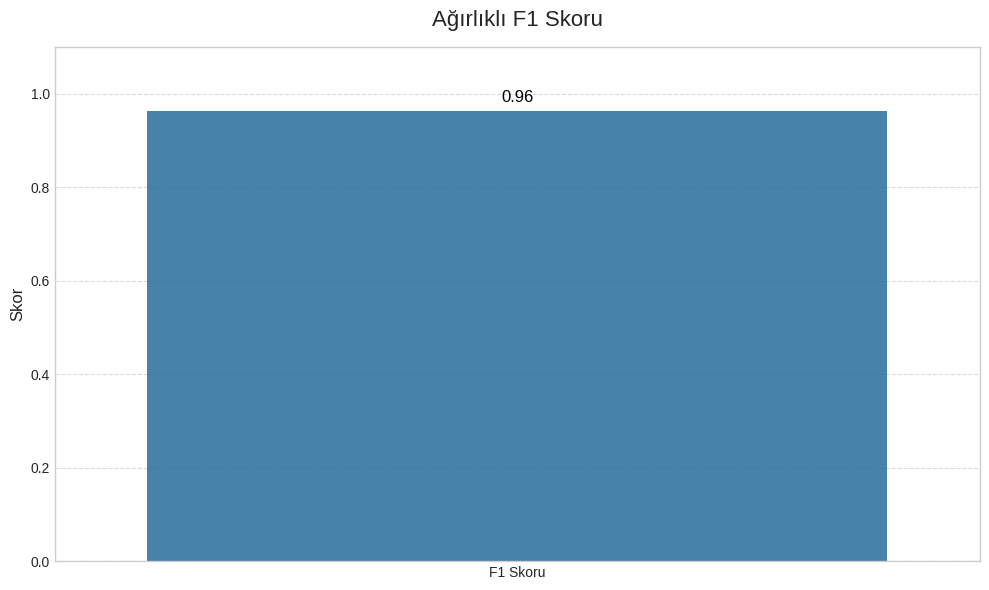

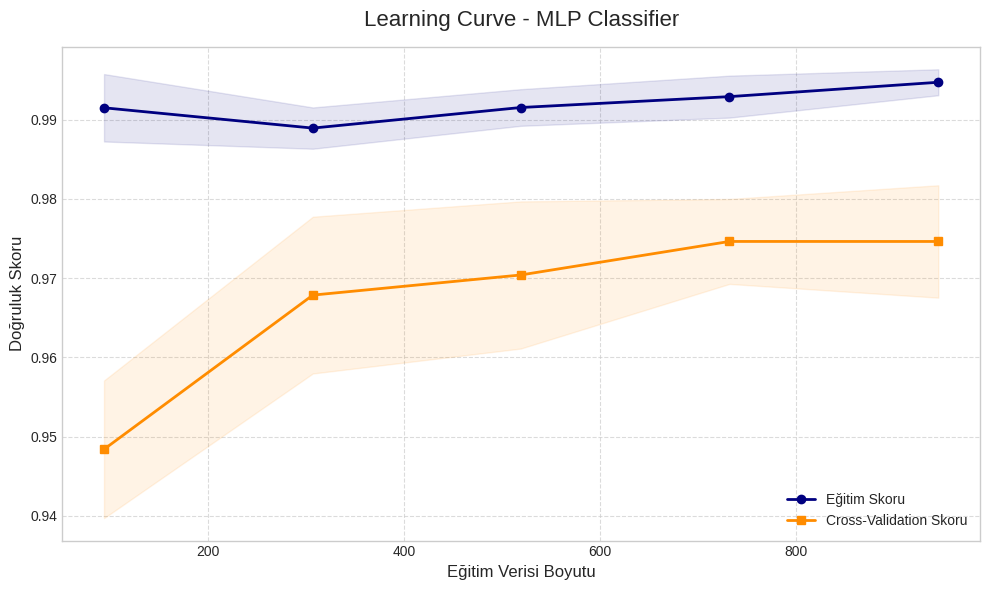

In [ ]:
# F1 Skor Grafiği
f1 = f1_score(y_test, y_pred, average='weighted')  # Ağırlıklı F1 skoru hesapla

plt.figure(figsize=(10, 6))
sns.barplot(x=['F1 Skoru'], y=[f1], palette=['#1f77b4'], alpha=0.9)

plt.text(0, f1 + 0.02, f'{f1:.2f}', ha='center', fontsize=12, color='black')

plt.ylim(0, 1.1)
plt.title('Ağırlıklı F1 Skoru', fontsize=16, pad=15)
plt.ylabel('Skor', fontsize=12)
plt.xlabel('')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Learning Curve Grafiği
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5))

# Ortalama ve standart sapmaları hesapla
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Öğrenme eğrisi çizimi
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Eğitim Skoru', marker='o', linewidth=2, color='navy')  #
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='navy')

plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Skoru', marker='s', linewidth=2, color='darkorange')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='darkorange')

plt.title('Learning Curve - MLP Classifier', fontsize=16, pad=15)
plt.xlabel('Eğitim Verisi Boyutu', fontsize=12)
plt.ylabel('Doğruluk Skoru', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Modelimizin genelleme ozelliğini ölçmek için 5-Fold Cross Validation kullanıldı

In [ ]:
# 5-Fold Cross Validation

# Girdi ve hedef değişkenleri ayır
X = data.drop(columns=['maintenance_required', 'failure_type'])  # 'failure_type' çıkarıldı (nedeni yukarıda açıklandı)
y = data['maintenance_required']

# Zaman damgası çıkarılır
if 'timestamp' in X.columns:
    X = X.drop(columns=['timestamp'])

# Sayısal ve kategorik sütunlar belirlenir
numerical_cols = ['temperature', 'vibration', 'humidity', 'pressure',
                  'energy_consumption', 'machine_status', 'anomaly_flag', 'predicted_remaining_life']
categorical_cols = ['machine_id']

# Sayısal veriler için dönüşüm (impute + standartlaştırma)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Kategorik veriler için One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Sayısal ve kategorik dönüşümleri tek bir yapı altında birleştir
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Diğer sütunları at
)

# MLPClassifier içeren pipeline (ön işleme + sınıflandırma)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', solver='adam',
                                 alpha=0.0001, learning_rate='constant', max_iter=150,
                                 random_state=42, early_stopping=True, n_iter_no_change=10))
])

# 5-Fold cross validation konfigürasyonu
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Her fold için doğruluk skorunu hesapla
scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)

# Sonuçların yazdırılması
print("====================================================")
print("K-Fold Cross Validation Sonuçları (Accuracy):")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score*100:.4f}")  # Her fold'un doğruluğu
print("====================================================")
print(f"Ortalama Doğruluk: {np.mean(scores)*100:.4f}")  # Ortalama başarı
print(f"Standart Sapma: {np.std(scores)*100:.4f}")  # Varyasyonun ölçüsü
print("====================================================")

K-Fold Cross Validation Sonuçları (Accuracy):
Fold 1: 91.5612
Fold 2: 95.7806
Fold 3: 92.7966
Fold 4: 91.1017
Fold 5: 96.6102
Ortalama Doğruluk: 93.5700
Standart Sapma: 2.2296


ROC AUC sınıflandırma modellerinin performansını ölçmek için kullanılır değerlerndirmelerde %100 modelin sınıfları mükemmel şekilde ayırdığının gösterir.

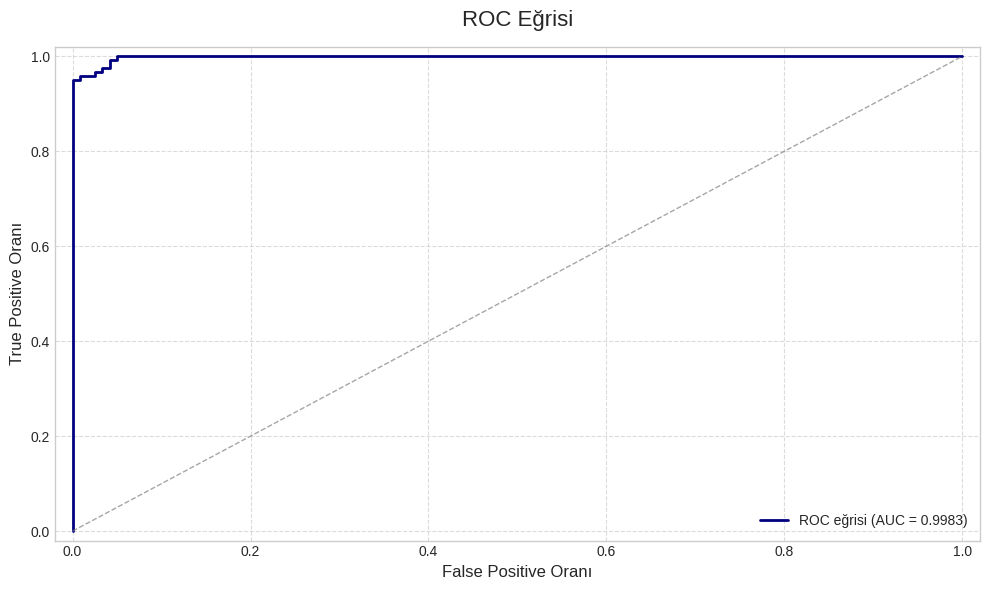

In [ ]:
# ROC Eğrisi ve AUC Skoru Görselleştirme

# Modeli eğit ve olasılık tahminlerini al
pipeline.fit(X_train, y_train)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# ROC AUC skoru hesapla
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_display = auc(fpr, tpr)

plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC eğrisi (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.7)

plt.title('ROC Eğrisi', fontsize=16, pad=15)
plt.xlabel('False Positive Oranı', fontsize=12)
plt.ylabel('True Positive Oranı', fontsize=12)

plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])

plt.tight_layout()
plt.show()

Bizim Modelimzde ROC AUC %100 çok yakın bir değer yani modelimiz sınıfları neredeyse hatasız bir şekilde ayırabiliyor

Hiperparametre Optimizasyonu yaparak modelimizn en üst doğruluk değerine ulşatımak için GridSearchCV kullanılmıştır

In [ ]:
# GridSearchCV ile Hiperparametre Optimizasyonu

k = data.drop(columns=['maintenance_required', 'failure_type'])
l = data['maintenance_required']

for col in k.columns:
    if np.issubdtype(k[col].dtype, np.datetime64) or k[col].astype(str).str.match(r'\d{4}-\d{2}-\d{2}').any():
        k = k.drop(columns=[col])

numerical_cols = k.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = k.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Pipeline: Ön işleme + MLPClassifier
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', MLPClassifier(random_state=42))
])

# Hiperparametre
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [100, 50, 75, 150, 200]
}

# GridSearchCV: Parametre kombinasyonlarını dener ve en iyisini bulur
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(k, l)

# Sonuçları yazdır
print("====================================================")
print("En İyi Skor: {:.2f}".format(grid_search.best_score_))
print("====================================================")
print("En İyi Parametreler:")
print(grid_search.best_params_)
print("====================================================")

En İyi Skor: 0.98
En İyi Parametreler:
{'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'constant', 'classifier__max_iter': 150}


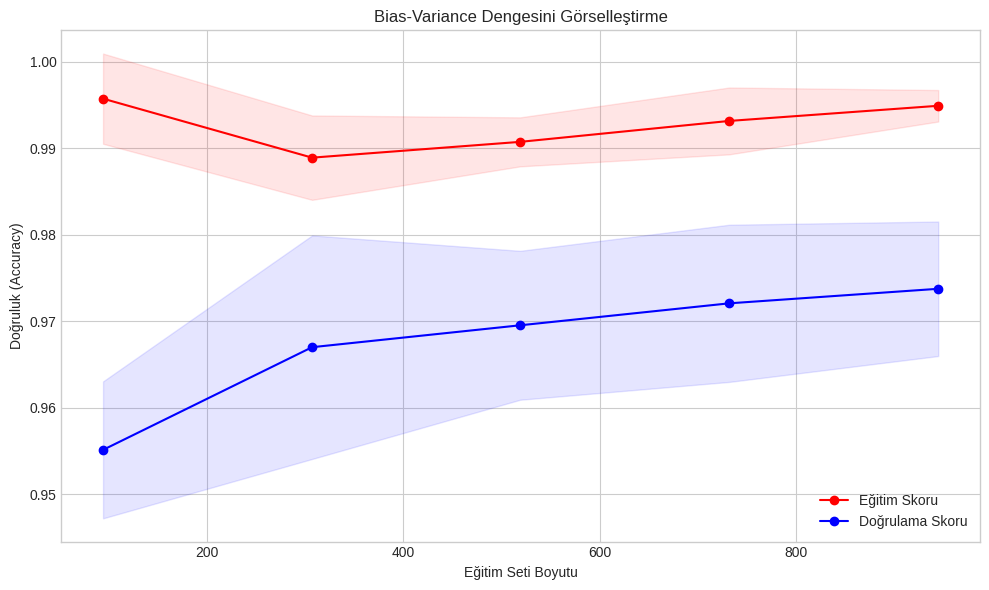

In [ ]:
# Bias-Variance Dengesini Görselleştirmek için Öğrenme Eğrisi

# Farklı eğitim seti boyutları için modelin eğitim ve doğrulama skorlarını hesapla
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y,
    cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,  # Veriyi karıştırarak daha tutarlı sonuçlar sağlar
    random_state=42
)

# Ortalama ve standart sapmaları hesapla
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Eğitim Skoru')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Doğrulama Skoru')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')

plt.title('Bias-Variance Dengesini Görselleştirme')
plt.xlabel('Eğitim Seti Boyutu')
plt.ylabel('Doğruluk (Accuracy)')

plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()